# **EECS 504 PS9: Panoramic Stitching**

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

[Mohammadreza] [Tavasoli Naeini], [tavasoli]

__Important__: after you download the .ipynb file, please name it as __\<your_uniquename\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.


# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping. 

The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors (we will be using ORB) from two input images. 

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. get_orb_features (1 point)

2. match_keypoints (1 point)

3. find_homography and transform_ransac (1 point each)

4. panoramic_stitching (1 points)

# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualize Input Images

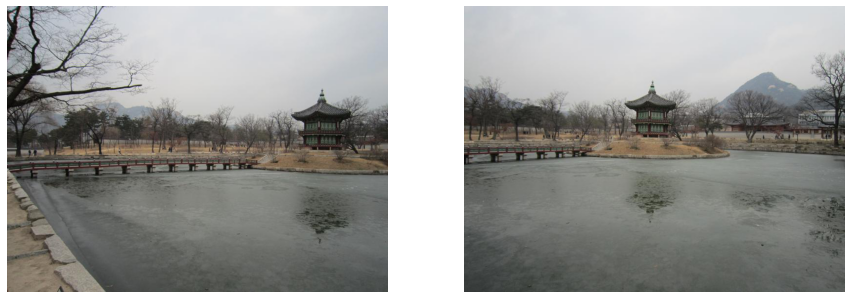

In [ ]:
img1 = plt.imread('img1.jpg',0)
img2 = plt.imread('img2.jpg',0)

def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1)
  ax[1].imshow(img2)

plot_imgs(img1, img2)

# Compute ORB Features and Match Keypoints

In [ ]:
def get_orb_features(img):
  '''
    Compute ORB features using cv2 library functions. Use default parameters when computing the keypoints.
    Input: 
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of ORB descriptors
  '''
  # ===============================================
     # Initiate STAR detector
  orb = cv2.ORB_create() 


     # compute the descriptors with ORB
  keypoints, descriptors = orb.detectAndCompute(img,None)


  # ===============================================
  return keypoints, descriptors

def match_keypoints(desc_1, desc_2, ratio=0.75):
  '''
    Compute matches between feature descriptors of two images using Lowe's ratio test. 
    You may use cv2 library functions.
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
  '''
  # ===============================================
  # TODO
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(desc_1,desc_2,k=2)
  good = []
  for m,n in matches:
    if m.distance < ratio*n.distance:
        good.append([m])
  matches = np.asarray(good)


  # ===============================================
  return matches

keypoints for img1 and img2


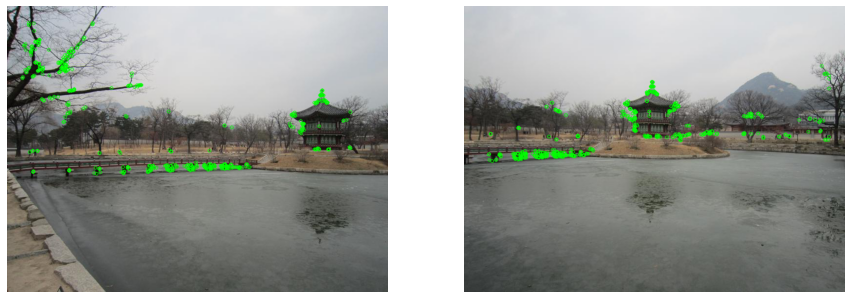

In [ ]:
kp_1, desc_1 = get_orb_features(img1)
#print(img1[0:1].shape)
kp_2, desc_2 = get_orb_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)


print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

orb feature matches


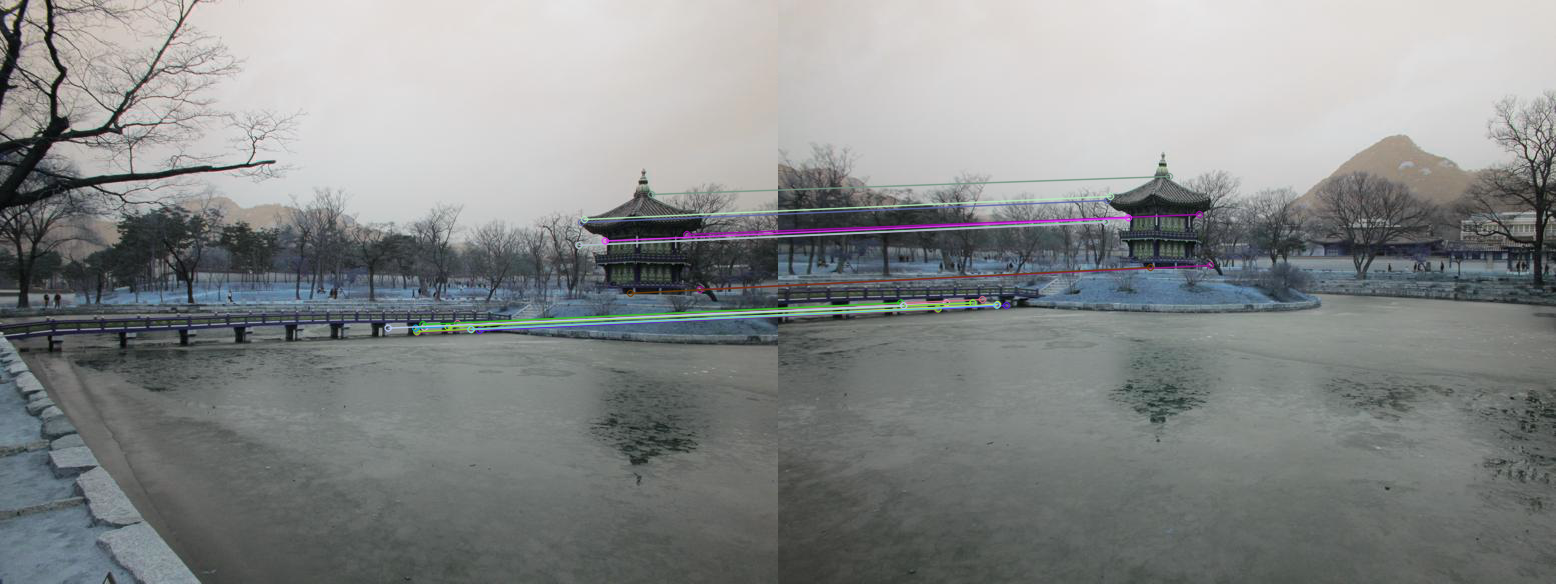

In [ ]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatchesKnn(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
print("orb feature matches")
cv2_imshow(match_plot)

# Compute Homography Matrix using RANSAC

In [ ]:
def find_homography(pts_1, pts_2):
  #print(len(pts_1), len(pts_2))
  A, b = [], []
  for i in range(4):
    x_1, y_1 = pts_1[i]
    x_2, y_2 = pts_2[i]
    r_a = np.asarray([x_1, y_1, 1., 0, 0, 0,0,0,0])
    r_b = np.asarray([0, 0, 0, x_1, y_1, 1.,0, 0,0])
    r_c = np.asarray([0, 0, 0, 0, 0, 0,x_1, y_1, 1])
    A.append(r_a)
    A.append(r_b)
    A.append(r_c)
    b.append([x_2])
    b.append([y_2])
    b.append([1])
  A = np.asarray(A)
  b = np.asarray(b)
  h = np.linalg.lstsq(A, b)[0]
  H = []
  H = np.asarray(h).reshape((3,3))
  return H

In [ ]:
def get_4_random(pts):
  size = len(pts)
  lst = []
  pts_1=[]
  while len(lst) < 4:
    i = random.randrange(size)
    if i not in lst:
			#print(pts[i])
      lst.append(i)
  for item in lst:
    pts_1.append(pts[item])
  return pts_1


In [ ]:
def transform_ransac(pts_1, pts_2):
  '''
    Implements RANSAC to estimate homography matrix.
    Input:
      pts_1, pts_1: (N, 2) matrices
    Return:
      best_model: homography matrix with most inliers
      You should use np.sum((pts_2_align - pts_1_align)**2) to compute the error. 
      The model is not guaranteed to improve after each iteration, but with more iterations there is a higher chance of randomly sampling points and computing a homography transformation that captures more inliers. In the standard RANSAC, typically you will randomly sample 4 sets of points to compute the homography matrix because you need 4 datapoints to solve the linear system of equations.
  '''
  # ===============================================
  best_H = np.eye(3)
  most_inliers = []
  for i in range(0, 20000):
    pts_1_4 = get_4_random(pts_1)
    pts_2_4 = get_4_random(pts_2)
    curr_H = find_homography(pts_1_4, pts_2_4)
    curr_inliers = []
    for i in range(len(pts_1)):
          x_1, y_1 = pts_1[i]
          x_2, y_2 = pts_2[i]
          p1=[x_1,y_1, 1]
          estimateP1 =np.dot(curr_H, p1) 
          p2=[x_2,y_2, 1]
          error=np.linalg.norm(p2-estimateP1)
          if error < 20:
            curr_inliers.append(p1)
    if len(curr_inliers) > len(most_inliers):
        most_inliers = curr_inliers
        best_H = curr_H
  best_model=best_H
  print(len(most_inliers))
  # TODO
  # ===============================================
  return best_model

# Panoramic Stitching

In [ ]:
def panoramic_stitching(img1, img2):
  '''
    Given a pair of overlapping images, generate a panoramic image. 
    Hint: use the functions that you've written in the previous parts.
    Hint: you may use OpenCV function to apply perspective wrapping.
    Input: 
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
  '''
  # ===============================================
  # TODO
  width = img1.shape[1] + img2.shape[1]
  height = img2.shape[0] 
  kp_1, desc_1 = get_orb_features(img1)
  kp_2, desc_2 = get_orb_features(img2)
  matches = match_keypoints(desc_1, desc_2)
  src = np.float32([ kp_1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,2)
  dst = np.float32([ kp_2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,2)
  H=transform_ransac(dst,src)
  result = cv2.warpPerspective(img2, H, (width, height))
  result[0:img1.shape[0], 0:img1.shape[1]] = img1
  # ===============================================
  return result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


34
[[ 1.05920963e+00  7.50400056e-02  2.19596847e+02]
 [ 2.88099823e-02  1.21620910e+00 -4.50899920e+01]
 [ 2.94410137e-14 -3.27618571e-14  1.00000000e+00]]


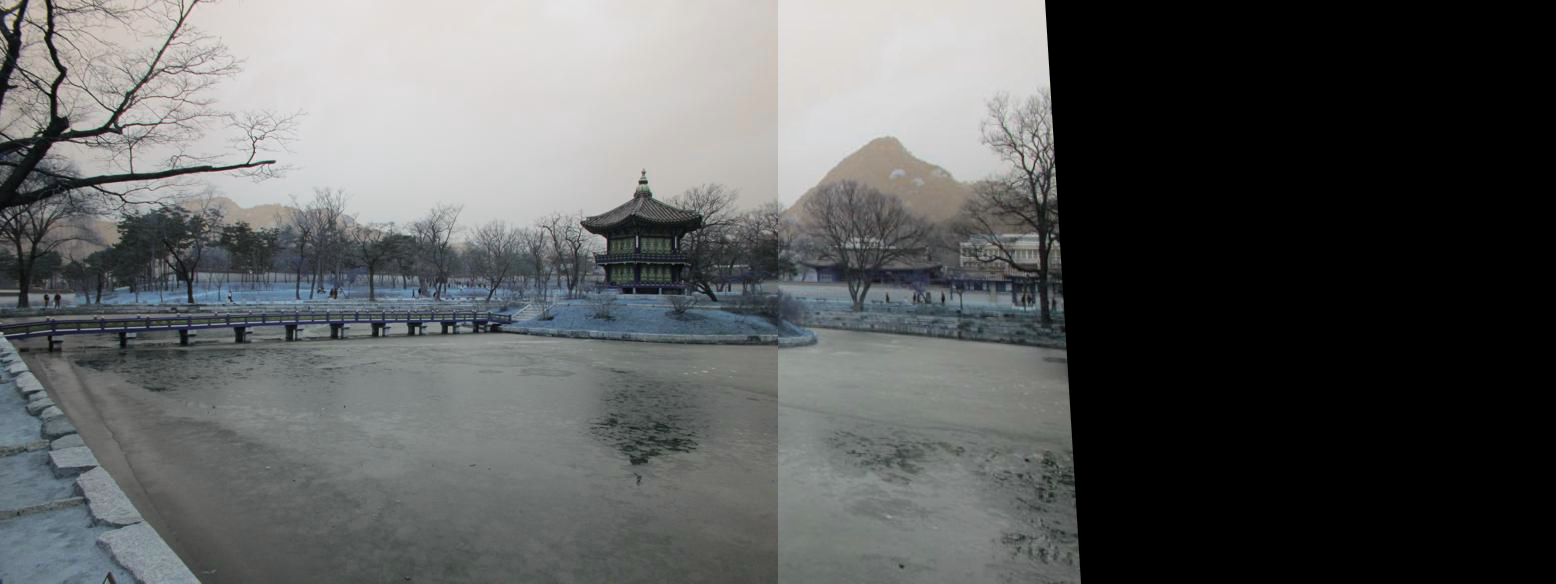

In [ ]:
result = panoramic_stitching(img1, img2)
cv2_imshow(result)